In [1]:
import os
import pickle
from pickle import load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import seaborn as sn
import datetime
import winsound

Using TensorFlow backend.


In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [3]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [4]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Found 2000 images belonging to 2 classes.


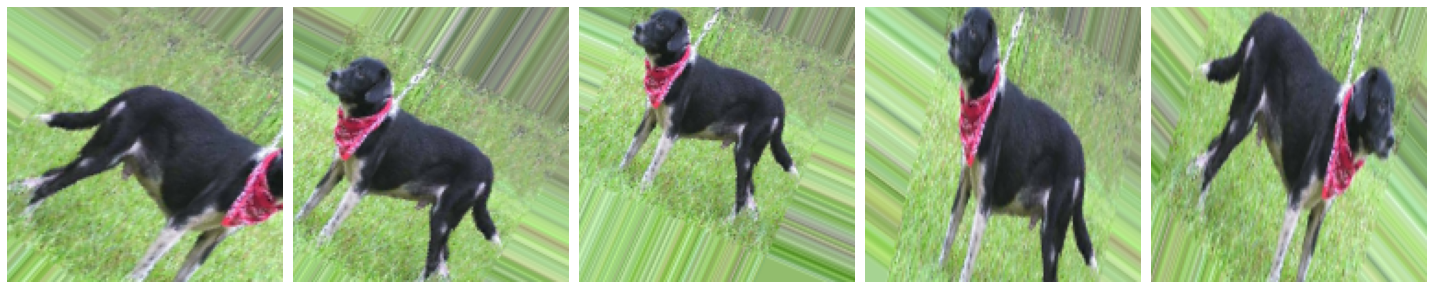

Found 1000 images belonging to 2 classes.


In [5]:
batch_size = 32
epochs = 30
IMG_HEIGHT = 150
IMG_WIDTH = 150

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=60,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

In [6]:
def base_model():
    model = Sequential([
        Conv2D(32, 3, padding='same', activation='relu', 
               input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        #Dropout(0.2),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        #Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1)
    ])

    #opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer="adam",
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model
    
model = base_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               11214976  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1



## Checkpoint and Early Stopping implemented it, in the callbacks

In [7]:
%%time

checkpoint_path = "cats_and_dogs/checkpoints/cp-{epoch}.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=1) # save every 1 epoch

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=10, # stop if metric wont improve after * epochs  
                                                  restore_best_weights=False)

#class CustomCallback(tf.keras.callbacks.Callback):
#
#    def on_train_batch_begin(self, batch, logs=None):
#        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

history = model.fit_generator(
              train_data_gen,
              steps_per_epoch=total_train // batch_size,
              epochs=epochs,
              validation_data=val_data_gen,
              validation_steps=total_val // batch_size,
              callbacks=[cp_callback, early_stopping]
          )

# Save model & history
model.save("cats_and_dogs/cats_and_dogs.h5")
with open('cats_and_dogs/ModelHistory', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
print("\n--------------------")

Epoch 1/30
61/62 [============================>.] - ETA: 0s - loss: 0.8990 - accuracy: 0.4979
Epoch 00001: saving model to cats_and_dogs/checkpoints/cp-1.ckpt
62/62 [==============================] - 53s 862ms/step - loss: 0.8958 - accuracy: 0.4985 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/30
61/62 [============================>.] - ETA: 0s - loss: 0.6921 - accuracy: 0.5046
Epoch 00002: saving model to cats_and_dogs/checkpoints/cp-2.ckpt
62/62 [==============================] - 53s 851ms/step - loss: 0.6920 - accuracy: 0.5051 - val_loss: 0.6792 - val_accuracy: 0.5312
Epoch 3/30
61/62 [============================>.] - ETA: 0s - loss: 0.6726 - accuracy: 0.5356
Epoch 00003: saving model to cats_and_dogs/checkpoints/cp-3.ckpt
62/62 [==============================] - 53s 851ms/step - loss: 0.6723 - accuracy: 0.5361 - val_loss: 0.6936 - val_accuracy: 0.6058
Epoch 4/30
61/62 [============================>.] - ETA: 0s - loss: 0.6533 - accuracy: 0.5785
Epoch 00004: saving model to cats

Epoch 29/30
61/62 [============================>.] - ETA: 0s - loss: 0.5448 - accuracy: 0.7040
Epoch 00029: saving model to cats_and_dogs/checkpoints/cp-29.ckpt
62/62 [==============================] - 53s 853ms/step - loss: 0.5453 - accuracy: 0.7043 - val_loss: 0.5474 - val_accuracy: 0.6925
Epoch 30/30
61/62 [============================>.] - ETA: 0s - loss: 0.5342 - accuracy: 0.7051
Epoch 00030: saving model to cats_and_dogs/checkpoints/cp-30.ckpt
62/62 [==============================] - 55s 880ms/step - loss: 0.5349 - accuracy: 0.7053 - val_loss: 0.5226 - val_accuracy: 0.7359

--------------------
Wall time: 26min 29s




## Find model's best checkpoint

In [8]:
# Create a basic model instance
model_2 = base_model()

# Evaluate the model
loss, acc = model_2.evaluate(val_data_gen, verbose=2)
print("Untrained model, accuracy: {:5.2f}%\n".format(100*acc))

# Loads the weights with the best validation accuracy
val_acc = history.history['val_accuracy']
best_checkpoint = "cats_and_dogs\checkpoints\cp-" + str(val_acc.index(max(val_acc)) + 1) +".ckpt"
model_2.load_weights(best_checkpoint)

# Re-evaluate the model
loss,acc = model_2.evaluate(val_data_gen, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))
print("At the epoch: {}".format(val_acc.index(max(val_acc)) + 1))

32/32 - 4s - loss: 0.7056 - accuracy: 0.5000
Untrained model, accuracy: 50.00%

32/32 - 4s - loss: 0.5281 - accuracy: 0.7380
Restored model, accuracy: 73.80%
At the epoch: 20


## Plots, Confusion Matrix & Statistics

Using data from the trained model

        loss  accuracy  val_loss  val_accuracy
25  0.554960  0.696138  0.533537      0.703629
26  0.540331  0.697154  0.518402      0.739919
27  0.525221  0.719512  0.536383      0.712702
28  0.545529  0.704268  0.547372      0.692540
29  0.536201  0.705285  0.522619      0.735887


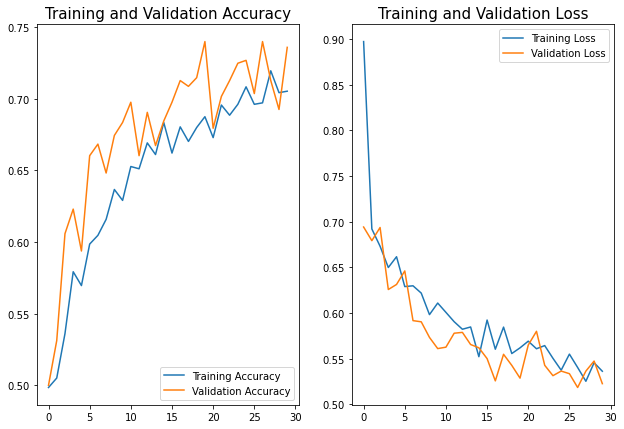



      The accuracy of classified dogs is: 76.80%  and of classified cats 69.20%
-------------------------------------------------------------------------------------
 The FALSE NEGATIVES are: 116 and they represent 23.20% of the wrong classified dogs
 If we want to be --% more precise of the correctly classified dogs
 FALSE NEGATIVES are now 2.20% which is 10.5 times more accurate than before
 This creates a 356.70% LOSS of the correctly classified cats(TNs)
 The original accuracy of the cats was 69.20% and it became 19.40%
-------------------------------------------------------------------------------------



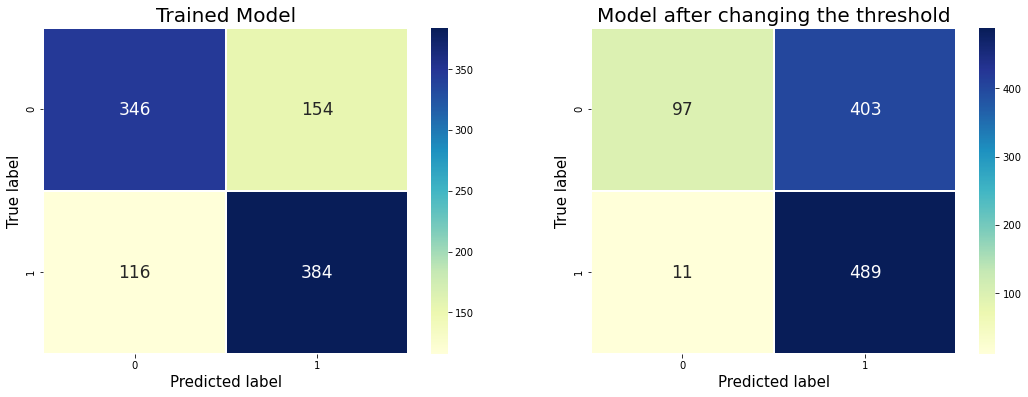

In [9]:
# Use current history or load from earlier training 
try:
    history
except NameError:
    print(">> Loading model")
    model = tf.keras.models.load_model('cats_and_dogs/cats_and_dogs.h5')
    print(">> Loading latest model's History from the file\n")
    with open('cats_and_dogs/ModelHistory', 'rb') as file_pi: 
        old_history = load(file_pi)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc = old_history['accuracy']
        val_acc = old_history['val_accuracy']
        loss = old_history['loss']
        val_loss = old_history['val_loss']        
else:
    print("Using data from the trained model\n")
    history_stats = pd.DataFrame(history.history) 
    print(history_stats.tail())
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()

#val_data_gen.reset()
Y_pred = model.predict_generator(val_data_gen, total_val // batch_size+1)

# Append 0 or 1 based on the predictions above.   { 0 CATS, 1 DOGS }
# Easy to specify how strong the correlation is by the number generated.
# Works as it is supposed to do when changing 0 to larger or smaller number
# by increasing the TPs for one class and increasing the FN for the other one.
y_pred, y2_pred = [], []
belief = 1.5
for i in range(total_val):     # Values without changing the threshold
    if Y_pred[i] > 0:          
        y_pred.append(1)
    else:
        y_pred.append(0)
        
for i in range(total_val):     # Numbers close to 1+ higher chance of representing a dog
    if Y_pred[i] > -belief:          # Numbers close to -1 higher chance of representing a cat
        y2_pred.append(1)
    else:
        y2_pred.append(0)
#print(np.array(y_pred))

CM = tf.math.confusion_matrix(val_data_gen.classes, y_pred) 
CM2 = tf.math.confusion_matrix(val_data_gen.classes, y2_pred)

plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.title('Trained Model', fontsize=20, ha='center')
sn.heatmap(CM, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.subplot(1,2,2)
plt.title('Model after changing the threshold', fontsize=20, ha='center')
sn.heatmap(CM2, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)


tn, fp, fn, tp = confusion_matrix(val_data_gen.classes, y_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(val_data_gen.classes, y2_pred).ravel()


print("\n\n      The accuracy of classified dogs is: {:.2f}%  and of classified cats {:.2f}%".format(
     (tp/num_dogs_val)*100, (tn/num_cats_val)*100))
print("-------------------------------------------------------------------------------------")
print(" The FALSE NEGATIVES are: {} and they represent {:.2f}% of the wrong classified dogs".format(
     fn, (fn/num_dogs_val)*100))
print(" If we want to be --% more precise of the correctly classified dogs".format(belief*100))
print(" FALSE NEGATIVES are now {:.2f}% which is {:.1f} times more accurate than before".format(
     (fn2/num_dogs_val)*100, (fn/num_dogs_val)/(fn2/num_dogs_val)))
print(" This creates a {:.2f}% LOSS of the correctly classified cats(TNs)".format(((tn/tn2)*100)))
print(" The original accuracy of the cats was {:.2f}% and it became {:.2f}%".format(
     (tn/num_cats_val)*100, (tn2/num_cats_val)*100))
print("-------------------------------------------------------------------------------------\n")

## ROC curves

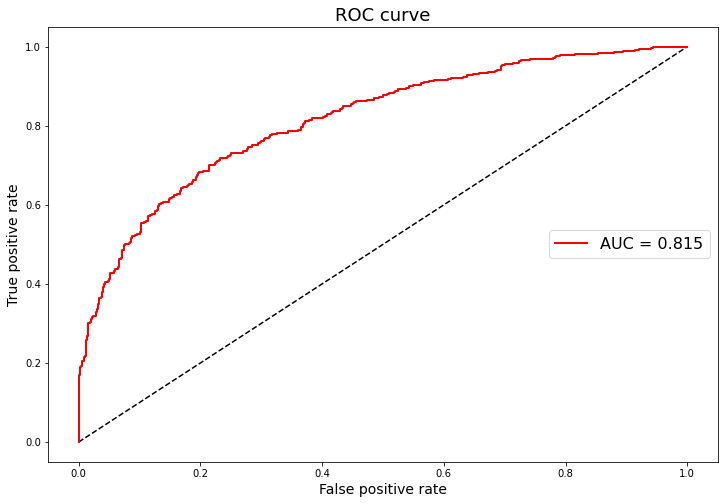

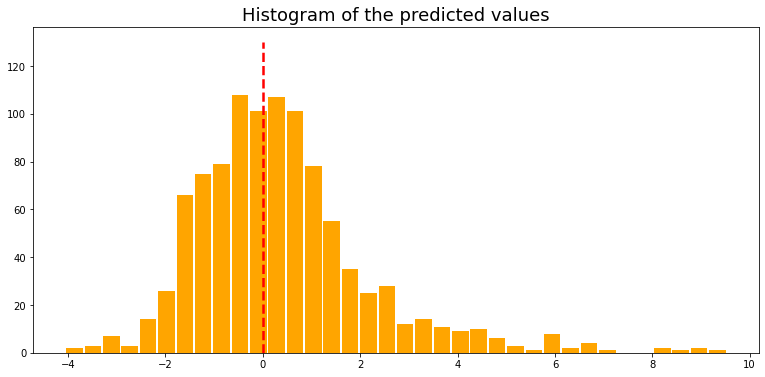

In [10]:
#(test_gen, steps=len(df_val), verbose=1)
y_pred_keras = model.predict_generator(val_data_gen, val_data_gen.samples // val_data_gen.batch_size+1) 
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, 'r-',label='AUC = {:.3f}'.format(auc_keras),linewidth=2)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='center right', prop={'size': 16})
plt.show()

# Histogram of the prediction values
plt.figure(figsize=(13,6))
plt.hist(y_pred_keras, bins="fd", color="orange", rwidth=0.9)
plt.plot([0, 0], [0, 130], "r--", linewidth=2.5)
plt.title('Histogram of the predicted values', fontsize=18)
plt.show()

# Real World Weight Binary Crossentropy

In [11]:
def create_rww_binary_crossentropy(fn_weight, fp_weight):    
    # fn_weight = 100, fp_weight=10 will penalize 10 times more the FN values than the FP ones
    # Like the treatment of having a binign malignant is 10 times more than 10 patients visiting the doctor 
    """
    binary_crossentropy is a special case of categorical_crossentropy.  
    The "all other" column is imputed. For single-label, an implementation is provided.
    However, this loss function is not very useful in a multi-label environment. 
    It only supports k=1. 
  
    In future work, we will provide an implementation for one target, 
    one miscategorization. Note that this will
    require a tensor of at lease size (k,k,2,2), where, the first 2 
    represents T/F of target, the second 2 represents the FP/FN of label. 

    We may also create a fully expressive loss function, which would require some
    efficient representation of a tensor of size (k, k, 2^k, 2^k)
  
    """  
    def binary_loss_function(target, output):
        output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
        logs = K.log(output) # shape (m, 1)
        logs_1_sub = K.log(1-output) # shape (m, 1)

        return - K.mean(target * fn_weight * logs + 
                       (1-target) * fp_weight * logs_1_sub)

    return binary_loss_function

In [12]:
tf.keras.backend.clear_session()

def create_rww_categorical_crossentropy(k, loss_type, fn_weights=None, fp_weights=None, return_weights=False):
    full_fn_weights = None
    full_fp_weights = None

    anti_eye = np.ones((k,k)) - np.eye(k)
    
    if (loss_type=="categorical_crossentropy"):
        full_fn_weights = np.identity((k))
        full_fp_weights = np.zeros((k, k)) # Softmax crossentropy ignores fp.

    elif(loss_type=="weighted_categorical_crossentropy"):
        full_fn_weights = np.eye(k) * fn_weights
        full_fp_weights = np.zeros((k, k)) # softmax crossentropy ignores fp
    
    elif(loss_type=="rww_crossentropy"):
        assert not np.count_nonzero(fn_weights * anti_eye)
        assert not np.count_nonzero(fp_weights * np.eye(k))

        full_fn_weights = fn_weights
        # Novel piece: allow any combination of fp.
        full_fp_weights = fp_weights
    
    else:
        raise Exception("unknown loss_type: " + str(loss_type))
   
    fn_wt = K.constant(full_fn_weights) # (k,k), always sparse along main diag. 
    fp_wt = K.constant(full_fp_weights) # (k,k), always dense except main diag. 

    def loss_function(target, output):
        output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
        logs = K.log(output) # shape (m, k), dense. 1 is good. 
        logs_1_sub = K.log(1-output) # shape (m, k), dense. 0 is good. 

        m_full_fn_weights = K.dot(target, fn_wt) # (m,k) . (k, k)
        m_full_fp_weights = K.dot(target, fp_wt) # (m,k) . (k, k)

        return - K.mean(m_full_fn_weights * logs + 
                        m_full_fp_weights * logs_1_sub)
  
    if (return_weights):
        return full_fn_weights, full_fp_weights
    else:
        return loss_function

In [13]:
#fn_weights, fp_weights = create_rww_categorical_crossentropy(2, "categorical_crossentropy", return_weights=True)
#fp_weights[1, 0] = 10
#rww_loss = create_rww_categorical_crossentropy(2, "rww_crossentropy", fn_weights, fp_weights)
#print("real world weighted cross entropy weights for k=2 classes.")
#print (fn_weights)
#print (fp_weights)

#print(rww_loss)

In [14]:
rww_loss = create_rww_binary_crossentropy(35, 10)  # fn weight 3.5 times more 
print(rww_loss)

<function create_rww_binary_crossentropy.<locals>.binary_loss_function at 0x000001A10060CEE8>


In [15]:
def rww_model():
    model = Sequential([
        Conv2D(32, 3, padding='same', activation='relu', 
               input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        #Dropout(0.2),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        #Dropout(0.2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    #opt = tf.keras.optimizers.SGD(learning_rate=0.1)
    adam_opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer="adam",  #"Adam"
                  loss=rww_loss,
                  metrics=['accuracy'])  # binary_accuracy
    return model
    
model = rww_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43808)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5607552   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [16]:
%%time

epochs=50

rww_checkpoint_path = "cats_and_dogs/rww_checkpoints/cp-{epoch}.ckpt"
rww_checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
rww_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rww_checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1,
                                                     period=1) 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  verbose=1,
                                                  patience=10, 
                                                  restore_best_weights=False)


rww_history = model.fit_generator(
                  train_data_gen,
                  steps_per_epoch=total_train // batch_size,
                  epochs=epochs,
                  validation_data=val_data_gen,
                  validation_steps=total_val // batch_size,
                  callbacks=[rww_cp_callback, early_stopping]
              )

# Save model & history
model.save("cats_and_dogs/rww_cats_and_dogs.h5")
with open('cats_and_dogs/RwwModelHistory', 'wb') as h_file:
    pickle.dump(rww_history.history, h_file)
    
print("\n--------------------")

Epoch 1/50
61/62 [============================>.] - ETA: 0s - loss: 13.8045 - accuracy: 0.4979
Epoch 00001: saving model to cats_and_dogs/rww_checkpoints/cp-1.ckpt
62/62 [==============================] - 42s 680ms/step - loss: 13.7789 - accuracy: 0.4959 - val_loss: 11.3195 - val_accuracy: 0.4960
Epoch 2/50
61/62 [============================>.] - ETA: 0s - loss: 11.4278 - accuracy: 0.4985
Epoch 00002: saving model to cats_and_dogs/rww_checkpoints/cp-2.ckpt
62/62 [==============================] - 43s 700ms/step - loss: 11.4339 - accuracy: 0.4990 - val_loss: 10.9472 - val_accuracy: 0.4960
Epoch 3/50
61/62 [============================>.] - ETA: 0s - loss: 11.3068 - accuracy: 0.5036
Epoch 00003: saving model to cats_and_dogs/rww_checkpoints/cp-3.ckpt
62/62 [==============================] - 42s 671ms/step - loss: 11.2937 - accuracy: 0.5041 - val_loss: 10.9667 - val_accuracy: 0.4970
Epoch 4/50
61/62 [============================>.] - ETA: 0s - loss: 11.1505 - accuracy: 0.5052
Epoch 00004

Epoch 28/50
61/62 [============================>.] - ETA: 0s - loss: 10.1689 - accuracy: 0.5687
Epoch 00028: saving model to cats_and_dogs/rww_checkpoints/cp-28.ckpt
62/62 [==============================] - 42s 685ms/step - loss: 10.1518 - accuracy: 0.5671 - val_loss: 9.9737 - val_accuracy: 0.5302
Epoch 29/50
61/62 [============================>.] - ETA: 0s - loss: 9.8426 - accuracy: 0.5722
Epoch 00029: saving model to cats_and_dogs/rww_checkpoints/cp-29.ckpt
62/62 [==============================] - 42s 675ms/step - loss: 9.8156 - accuracy: 0.5736 - val_loss: 9.7587 - val_accuracy: 0.5494
Epoch 30/50
61/62 [============================>.] - ETA: 0s - loss: 9.8836 - accuracy: 0.5868
Epoch 00030: saving model to cats_and_dogs/rww_checkpoints/cp-30.ckpt
62/62 [==============================] - 42s 684ms/step - loss: 9.9068 - accuracy: 0.5859 - val_loss: 9.9469 - val_accuracy: 0.5383
Epoch 31/50
61/62 [============================>.] - ETA: 0s - loss: 9.7236 - accuracy: 0.5847
Epoch 00031:

Using data from the trained model

        loss  accuracy   val_loss  val_accuracy
45  9.584148  0.607215   9.589621      0.661290
46  9.283774  0.623476   9.804350      0.618952
47  9.515903  0.634146  10.129063      0.681452
48  9.312913  0.623984   9.706849      0.588710
49  9.503256  0.623984   9.454367      0.625000

Best checkpoint at: cats_and_dogs\rww_checkpoints\cp-48.ckpt



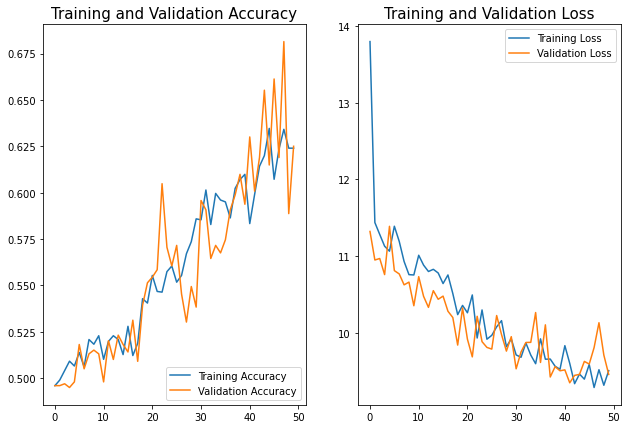

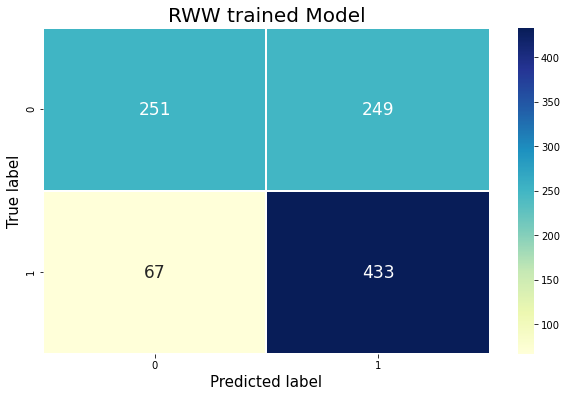

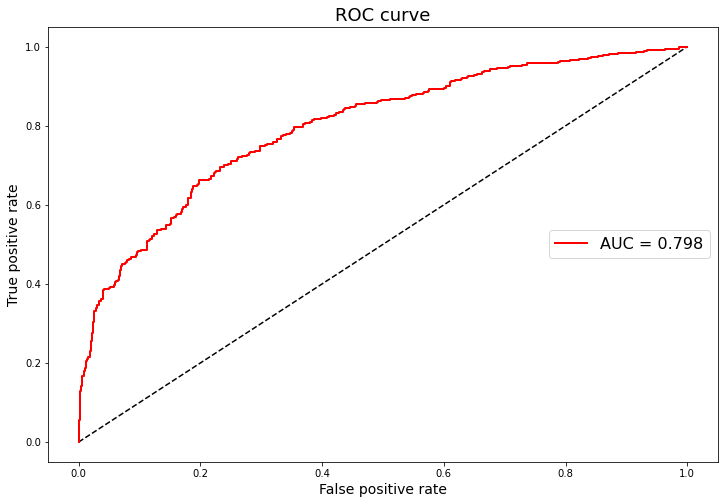

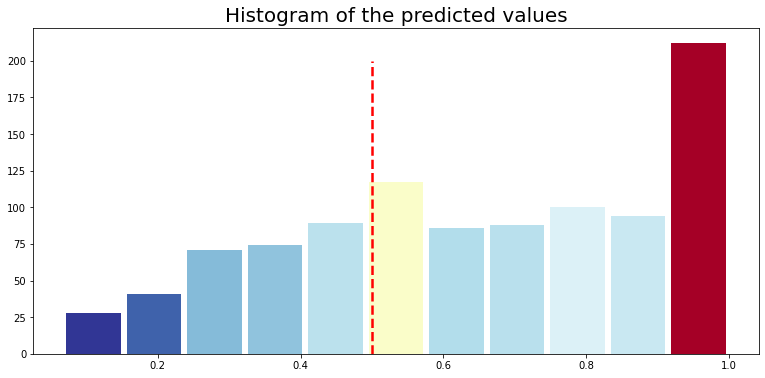

In [17]:
# Use current history or load from earlier training 
try:
    rww_history
except NameError:
    model = tf.keras.models.load_model('cats_and_dogs/rww_cats_and_dogs.h5',
                                       custom_objects={'binary_loss_function': create_rww_binary_crossentropy(35,10)})
    print("\n>> Loading model with loss function:\n{}".format(model.loss))
    print("\n>> Loading latest model's History from the file\n")
    with open('cats_and_dogs/RwwModelHistory', 'rb') as h_file: 
        old_history = load(h_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc = old_history['accuracy']
        val_acc = old_history['val_accuracy']
        loss = old_history['loss']
        val_loss = old_history['val_loss']        
else:
    print("Using data from the trained model\n")
    history_stats = pd.DataFrame(rww_history.history) 
    print(history_stats.tail())
    
    acc = rww_history.history['accuracy']
    val_acc = rww_history.history['val_accuracy']
    loss = rww_history.history['loss']
    val_loss = rww_history.history['val_loss']

# Find the weights with the best validation accuracy 
best_weight_model = rww_model()
rww_best_checkpoint = "cats_and_dogs\\rww_checkpoints\cp-" + str(val_acc.index(max(val_acc)) + 1) +".ckpt"
print("\nBest checkpoint at: {}\n".format(rww_best_checkpoint))
best_weight_model.load_weights(rww_best_checkpoint)

# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

plt.figure(figsize=(16, 7))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15)

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15)
plt.show()

#val_data_gen.reset()
Y_pred = best_weight_model.predict(val_data_gen, batch_size=None)
#y_pred = np.argmax(Y_pred, axis=1)

y_pred = []
for i in range(total_val):     # Threshold set in 0.5 as intended
    if Y_pred[i] >= 0.5:          
        y_pred.append(1)
    else:
        y_pred.append(0)
#print(y_pred)

CM = tf.math.confusion_matrix(val_data_gen.classes, y_pred) 

plt.figure(figsize = (10,6))
plt.title('RWW trained Model', fontsize=20, ha='center')
sn.heatmap(CM, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

tn, fp, fn, tp = confusion_matrix(val_data_gen.classes, y_pred).ravel()


# Roc curve
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(val_data_gen.classes, Y_pred)
auc_keras2 = auc(fpr_keras2, tpr_keras2)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras2, tpr_keras2, 'r-',label='AUC = {:.3f}'.format(auc_keras2),linewidth=2)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='center right', prop={'size': 16})
plt.show()

# Histogram of the prediction values
plt.figure(figsize=(13,6))
cm = plt.cm.get_cmap('RdYlBu_r')
n, _, patches = plt.hist(Y_pred, bins="fd", rwidth=0.9)
col = (n-n.min())/(n.max()-n.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.plot([0.5, 0.5], [0, 200], 'r--', linewidth=2.5)
plt.title('Histogram of the predicted values', fontsize=20)
plt.show()


## Another way of deciding of the lessions. Specify the threshold and give the ground vs the predicted values. Specifying the threshold will decide about the output ( 0 or 1)

In [18]:
m = tf.keras.metrics.BinaryAccuracy(
        name='binary_accuracy', dtype=None, threshold=0.9
)

_ = m.update_state([[1]], [[0.6]])   # update_state([y_true] , [y_pred])
m.result().numpy()

0.0

In [19]:
# Food Is Ready
duration = 2000  # milliseconds
freq = 600  # Hz
winsound.Beep(freq, duration)